# Azure cosmos nosql database

### Import Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from azure.cosmos import CosmosClient, exceptions, PartitionKey
import json
import uuid
from azure.cosmos.exceptions import CosmosResourceExistsError

### Connect to Cosmos DB

In [2]:
URL = "https://aaric1082.documents.azure.com:443/"
KEY = ""
client = CosmosClient(URL, credential=KEY)

### Database creation in Cosmos DB

the database already created in Cosmos DB and need not to be run again therefore, they are commented to avoid duplication.

In [3]:
def create_DB(client, database_name):
    ''' Create a database if it doesn't exist 

    parameters: 
        client: CosmosClient
        database_name: string

    returns: 
        database: Database
    '''
    try:
        database = client.create_database(database_name)
        database = client.get_database_client(database_name)
        print("Created database: {0}".format(database.id))
    except exceptions.CosmosResourceExistsError:
        database = client.get_database_client(database_name)
        print("Database {0} already exists".format(database.id))
    return database

In [4]:
# Create GeoDB
database = create_DB(client, "GeoDB")

Database GeoDB already exists


In [5]:
def create_container(database, container_name):
    '''
    Create a container if it doesn't exist

    parameters: 
        database: Database
        container_name: string

    returns: 
        container: Container
    '''

    try:
        container = database.create_container(id=container_name, partition_key=PartitionKey(path='/id', kind='Hash'))
        container = database.get_container_client(container_name)
        print("Created container: {0}".format(container.id))
    except exceptions.CosmosResourceExistsError:
        container = database.get_container_client(container_name)
        print("Container {0} already exists".format(container.id))
    return container

In [6]:
# Create subregions
container = create_container(database, "subregions")

Container subregions already exists


In [7]:
def ingest_data(container, path):
    '''
    Ingest data to Cosmos DB

    parameters: 
        container: Container to insert data
        data path: string

    returns: 
        None
    '''
    with open(path, "r") as file:
        data = json.load(file)
    
    for item in data:
        if "id" in item:
            item_id = str(item["id"])  # Convert id to string if it's not already
        else:
            item_id = str(uuid.uuid4())  # Generate a UUID as id if no id field is present
        
        # Check if item with the same ID already exists
        try:
            item_to_insert = item.copy()  # Create a copy of the item to avoid modifying the original
            item_to_insert["id"] = item_id  # Set the correct ID for the item
            container.create_item(body=item_to_insert)
        except CosmosResourceExistsError:
            print(f"Item with ID '{item_id}' already exists. Skipping insertion.")

    print("Data uploaded successfully to Cosmos DB.")


In [8]:
#ingest_data(container, "Geo_data/subregions.json")

In [9]:
container = create_container(database, "countries")

Container countries already exists


In [10]:
#ingest_data(container, "Geo_data/countries.json")

In [11]:
container = create_container(database, "states")

Container states already exists


In [12]:
#ingest_data(container, "Geo_data/states.json")

In [13]:
container = create_container(database, "cities")

Container cities already exists


In [14]:
#ingest_data(container, "Geo_data/cities.json")

### Querying Cosmos DB

In [15]:
# load database and containers

database = client.get_database_client("GeoDB")
regions = database.get_container_client("regions")
subregions = database.get_container_client("subregions")
countries = database.get_container_client("countries")
states = database.get_container_client("states")
cities = database.get_container_client("cities")

In [16]:
def get_result(query, container):
    '''
    get result from the db for the query and store it in a dataframe

    parameters: 
        query: string
        container: Container

    returns: 
        df: dataframe
    '''
    query_results = container.query_items(query=query, enable_cross_partition_query=True) # code to get the result
    results_list = list(query_results)
    df = pd.DataFrame(results_list)
    return df

#### Exploring basic query operations available in Cosmos DB

***SELECT***

List all regions in the database.

In [17]:
query = "select * from region r"
result = regions.query_items(query=query, enable_cross_partition_query=True)
result

<iterator object azure.core.paging.ItemPaged at 0x156477ec0>

The result is a object of type `CosmosQueryItemsResponse`, to view the result iterate over the result and print the result

In [18]:
for res in result:
    print(res)

{'id': '1', 'name': 'Africa', 'translations': {'kr': '아프리카', 'pt-BR': 'África', 'pt': 'África', 'nl': 'Afrika', 'hr': 'Afrika', 'fa': 'آفریقا', 'de': 'Afrika', 'es': 'África', 'fr': 'Afrique', 'ja': 'アフリカ', 'it': 'Africa', 'cn': '非洲', 'tr': 'Afrika'}, 'wikiDataId': 'Q15', '_rid': 'Lio3AMYlHRoBAAAAAAAAAA==', '_self': 'dbs/Lio3AA==/colls/Lio3AMYlHRo=/docs/Lio3AMYlHRoBAAAAAAAAAA==/', '_etag': '"4100f187-0000-0200-0000-66181bc20000"', '_attachments': 'attachments/', '_ts': 1712856002}
{'id': '2', 'name': 'Americas', 'translations': {'kr': '아메리카', 'pt-BR': 'América', 'pt': 'América', 'nl': 'Amerika', 'hr': 'Amerika', 'fa': 'قاره آمریکا', 'de': 'Amerika', 'es': 'América', 'fr': 'Amérique', 'ja': 'アメリカ州', 'it': 'America', 'cn': '美洲', 'tr': 'Amerika'}, 'wikiDataId': 'Q828', '_rid': 'Lio3AMYlHRoCAAAAAAAAAA==', '_self': 'dbs/Lio3AA==/colls/Lio3AMYlHRo=/docs/Lio3AMYlHRoCAAAAAAAAAA==/', '_etag': '"4100f287-0000-0200-0000-66181bc20000"', '_attachments': 'attachments/', '_ts': 1712856002}
{'id': '3'

To have a better view of the result, the result is stored in a dataframe

In [19]:
regions_df = get_result(query, regions)
regions_df

,id,name,translations,wikiDataId,_rid,_self,_etag,_attachments,_ts
0,1,Africa,"{'kr': '아프리카', 'pt-BR': 'África', 'pt': 'Áfric...",Q15,Lio3AMYlHRoBAAAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AMYlHRo=/docs/Lio3AMYlH...,"""4100f187-0000-0200-0000-66181bc20000""",attachments/,1712856002
1,2,Americas,"{'kr': '아메리카', 'pt-BR': 'América', 'pt': 'Amér...",Q828,Lio3AMYlHRoCAAAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AMYlHRo=/docs/Lio3AMYlH...,"""4100f287-0000-0200-0000-66181bc20000""",attachments/,1712856002
2,3,Asia,"{'kr': '아시아', 'pt-BR': 'Ásia', 'pt': 'Ásia', '...",Q48,Lio3AMYlHRoDAAAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AMYlHRo=/docs/Lio3AMYlH...,"""4100f387-0000-0200-0000-66181bc20000""",attachments/,1712856002
3,4,Europe,"{'kr': '유럽', 'pt-BR': 'Europa', 'pt': 'Europa'...",Q46,Lio3AMYlHRoEAAAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AMYlHRo=/docs/Lio3AMYlH...,"""4100f487-0000-0200-0000-66181bc20000""",attachments/,1712856002
4,5,Oceania,"{'kr': '오세아니아', 'pt-BR': 'Oceania', 'pt': 'Oce...",Q55643,Lio3AMYlHRoFAAAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AMYlHRo=/docs/Lio3AMYlH...,"""4100f587-0000-0200-0000-66181bc20000""",attachments/,1712856002
5,6,Polar,"{'kr': '남극', 'pt-BR': 'Antártida', 'pt': 'Antá...",Q51,Lio3AMYlHRoGAAAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AMYlHRo=/docs/Lio3AMYlH...,"""4100f687-0000-0200-0000-66181bc20000""",attachments/,1712856002


***Filter***

Find all the states in united states.

In [20]:
query = "select * from states s where s.country_name = 'United States'"
result_df = get_result(query, states)
result_df.head() # due to the large amount of data, we only show the first 5 rows for notebook readability

,id,name,country_id,country_code,country_name,state_code,type,latitude,longitude,_rid,_self,_etag,_attachments,_ts
0,1456,Alabama,233,US,United States,AL,state,32.31823140,-86.90229800,Lio3AJaAqi-nEgAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AJaAqi8=/docs/Lio3AJaAq...,"""0b001d46-0000-0200-0000-661d67e30000""",attachments/,1713203171
1,1400,Alaska,233,US,United States,AK,state,64.20084130,-149.49367330,Lio3AJaAqi-oEgAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AJaAqi8=/docs/Lio3AJaAq...,"""0b001e46-0000-0200-0000-661d67e30000""",attachments/,1713203171
2,1424,American Samoa,233,US,United States,AS,outlying area,-14.27097200,-170.13221700,Lio3AJaAqi-pEgAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AJaAqi8=/docs/Lio3AJaAq...,"""0b001f46-0000-0200-0000-661d67e30000""",attachments/,1713203171
3,1434,Arizona,233,US,United States,AZ,state,34.04892810,-111.09373110,Lio3AJaAqi-qEgAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AJaAqi8=/docs/Lio3AJaAq...,"""0b002046-0000-0200-0000-661d67e30000""",attachments/,1713203171
4,1444,Arkansas,233,US,United States,AR,state,35.20105000,-91.83183340,Lio3AJaAqi-rEgAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AJaAqi8=/docs/Lio3AJaAq...,"""0b002146-0000-0200-0000-661d67e30000""",attachments/,1713203172


***Group by***

Find the number of countries in each sub regions in asian region.

In [21]:
query = '''Select * from countries c where c.region = 'Asia' '''
result_df = get_result(query, countries)
result_df.head()

,id,name,iso3,iso2,numeric_code,phone_code,capital,currency,currency_name,currency_symbol,...,translations,latitude,longitude,emoji,emojiU,_rid,_self,_etag,_attachments,_ts
0,1,Afghanistan,AFG,AF,004,93,Kabul,AFN,Afghan afghani,؋,...,"{'kr': '아프가니스탄', 'pt-BR': 'Afeganistão', 'pt':...",33.00000000,65.00000000,🇦🇫,U+1F1E6 U+1F1EB,Lio3AMK5aMcBAAAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AMK5aMc=/docs/Lio3AMK5a...,"""10000523-0000-0200-0000-661d66970000""",attachments/,1713202839
1,12,Armenia,ARM,AM,051,374,Yerevan,AMD,Armenian dram,֏,...,"{'kr': '아르메니아', 'pt-BR': 'Armênia', 'pt': 'Arm...",40.00000000,45.00000000,🇦🇲,U+1F1E6 U+1F1F2,Lio3AMK5aMcMAAAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AMK5aMc=/docs/Lio3AMK5a...,"""10001023-0000-0200-0000-661d66970000""",attachments/,1713202839
2,16,Azerbaijan,AZE,AZ,031,994,Baku,AZN,Azerbaijani manat,m,...,"{'kr': '아제르바이잔', 'pt-BR': 'Azerbaijão', 'pt': ...",40.50000000,47.50000000,🇦🇿,U+1F1E6 U+1F1FF,Lio3AMK5aMcQAAAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AMK5aMc=/docs/Lio3AMK5a...,"""10001423-0000-0200-0000-661d66970000""",attachments/,1713202839
3,18,Bahrain,BHR,BH,048,973,Manama,BHD,Bahraini dinar,.د.ب,...,"{'kr': '바레인', 'pt-BR': 'Bahrein', 'pt': 'Barém...",26.00000000,50.55000000,🇧🇭,U+1F1E7 U+1F1ED,Lio3AMK5aMcRAAAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AMK5aMc=/docs/Lio3AMK5a...,"""10001523-0000-0200-0000-661d66970000""",attachments/,1713202839
4,19,Bangladesh,BGD,BD,050,880,Dhaka,BDT,Bangladeshi taka,৳,...,"{'kr': '방글라데시', 'pt-BR': 'Bangladesh', 'pt': '...",24.00000000,90.00000000,🇧🇩,U+1F1E7 U+1F1E9,Lio3AMK5aMcSAAAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AMK5aMc=/docs/Lio3AMK5a...,"""10001623-0000-0200-0000-661d66970000""",attachments/,1713202839


Cosmos DB not support group by query. For grouping we will use pandas

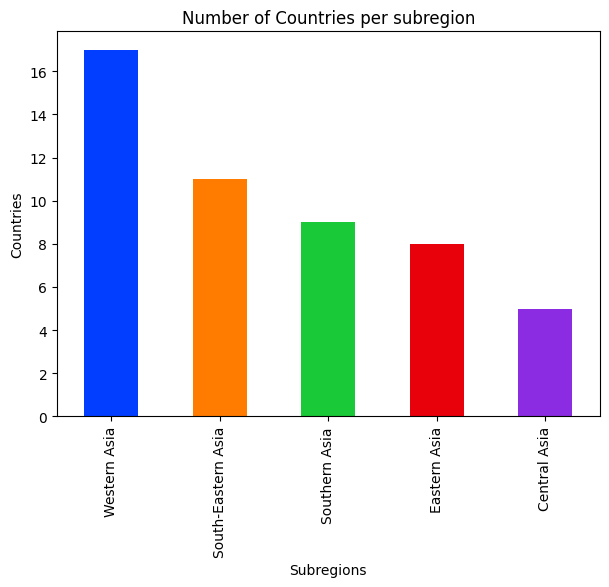

In [22]:
plt.figure(figsize=(7, 5))
colors = sns.color_palette('bright')
result_df['subregion'].value_counts().plot(kind='bar', color=colors) # counts the number of countries in each subregion from the dataframe and plots them
plt.xlabel('Subregions')
plt.ylabel('Countries')
plt.title('Number of Countries per subregion')
plt.show()

***Count***

Count the number of islands associated with United States

In [23]:
query = "SELECT VALUE COUNT(1) FROM states s WHERE s.country_name = 'United States' AND s.type = 'islands / groups of islands'"
query_results = states.query_items(query=query, enable_cross_partition_query=True)
count = list(query_results)
print("There are ", count[0], " islands in United States")


There are  9  islands in United States


***Order by***

List all states in India in alphabetical order

In [24]:
query = ''' select * from states s where s.country_name = 'India'  order by s.name '''
result_df = get_result(query, states)
result_df.head()

,id,name,country_id,country_code,country_name,state_code,type,latitude,longitude,_rid,_self,_etag,_attachments,_ts
0,4023,Andaman and Nicobar Islands,101,IN,India,AN,Union territory,11.74008670,92.65864010,Lio3AJaAqi9gBgAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AJaAqi8=/docs/Lio3AJaAq...,"""0b007f39-0000-0200-0000-661d67a70000""",attachments/,1713203111
1,4017,Andhra Pradesh,101,IN,India,AP,state,15.91289980,79.73998750,Lio3AJaAqi9hBgAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AJaAqi8=/docs/Lio3AJaAq...,"""0b008039-0000-0200-0000-661d67a70000""",attachments/,1713203111
2,4024,Arunachal Pradesh,101,IN,India,AR,state,28.21799940,94.72775280,Lio3AJaAqi9iBgAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AJaAqi8=/docs/Lio3AJaAq...,"""0b008139-0000-0200-0000-661d67a70000""",attachments/,1713203111
3,4027,Assam,101,IN,India,AS,state,26.20060430,92.93757390,Lio3AJaAqi9jBgAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AJaAqi8=/docs/Lio3AJaAq...,"""0b008239-0000-0200-0000-661d67a70000""",attachments/,1713203111
4,4037,Bihar,101,IN,India,BR,state,25.09607420,85.31311940,Lio3AJaAqi9kBgAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AJaAqi8=/docs/Lio3AJaAq...,"""0b008339-0000-0200-0000-661d67a70000""",attachments/,1713203111


***Querying sub-elements***

Find the Chinese names of countries in Americas region

In [25]:
query = ''' select c.name as Name,c.translations.cn as Chinese_names from countries c where c.region = 'Americas' '''
result_df = get_result(query, countries)
result_df.head()

,Name,Chinese_names
0,Anguilla,安圭拉
1,Antigua and Barbuda,安提瓜和巴布达
2,Argentina,阿根廷
3,Aruba,阿鲁巴
4,Barbados,巴巴多斯


***Join query***

In **Azure Cosmos DB**, you cannot directly reference or call an item from one container into another container using a query in the same way you might perform a join operation in a relational database. Cosmos DB does not support cross-container queries or joins natively. Each container in Cosmos DB operates independently, and data from one container cannot be directly accessed or queried from another container using SQL-like queries.

However, you can achieve a similar effect by designing your data model to include references or IDs that link items across containers. Then, you can use application logic to fetch related data from different containers based on these references. Here's an example approach:

List all states in United Kingdom

In [26]:
# Query Container countries to get item with linked_id
query_a = f"SELECT c.id FROM countries c WHERE c.name = 'United Kingdom'"
result_a = list(countries.query_items(query=query_a, enable_cross_partition_query=True))
    
# Query Container states using the retrieved item's data
if result_a:
        linked_item_data = result_a[0]  # Get the first item in the result set
        query_b = f"SELECT * FROM states s WHERE s.country_id = {linked_item_data['id']}" # linking the foreign key from countries to states
        result_b = list(states.query_items(query=query_b, enable_cross_partition_query=True))

result = pd.DataFrame(result_b)
result.head()

,id,name,country_id,country_code,country_name,state_code,type,latitude,longitude,_rid,_self,_etag,_attachments,_ts
0,2463,Aberdeen,232,GB,United Kingdom,ABE,None,57.14971700,-2.09427800,Lio3AJaAqi-wEQAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AJaAqi8=/docs/Lio3AJaAq...,"""0b001845-0000-0200-0000-661d67df0000""",attachments/,1713203167
1,2401,Aberdeenshire,232,GB,United Kingdom,ABD,None,57.28687230,-2.38156840,Lio3AJaAqi-xEQAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AJaAqi8=/docs/Lio3AJaAq...,"""0b001945-0000-0200-0000-661d67df0000""",attachments/,1713203167
2,2387,Angus,232,GB,United Kingdom,ANS,None,37.27578860,-95.65010330,Lio3AJaAqi-yEQAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AJaAqi8=/docs/Lio3AJaAq...,"""0b001a45-0000-0200-0000-661d67df0000""",attachments/,1713203167
3,2533,Antrim,232,GB,United Kingdom,ANT,None,54.71953380,-6.20724980,Lio3AJaAqi-zEQAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AJaAqi8=/docs/Lio3AJaAq...,"""0b001b45-0000-0200-0000-661d67df0000""",attachments/,1713203167
4,2412,Antrim and Newtownabbey,232,GB,United Kingdom,ANN,None,54.69568870,-5.94810690,Lio3AJaAqi-0EQAAAAAAAA==,dbs/Lio3AA==/colls/Lio3AJaAqi8=/docs/Lio3AJaAq...,"""0b001c45-0000-0200-0000-661d67df0000""",attachments/,1713203167


Additional queries

Find the most commonly used currecy in the world

In [27]:
query = ''' select c.name, c.currency, c.currency_name, c.currency_symbol
from countries c'''
result_df = get_result(query, countries)
result_df.head()

,name,currency,currency_name,currency_symbol
0,Afghanistan,AFN,Afghan afghani,؋
1,Aland Islands,EUR,Euro,€
2,Albania,ALL,Albanian lek,Lek
3,Algeria,DZD,Algerian dinar,دج
4,American Samoa,USD,US Dollar,$


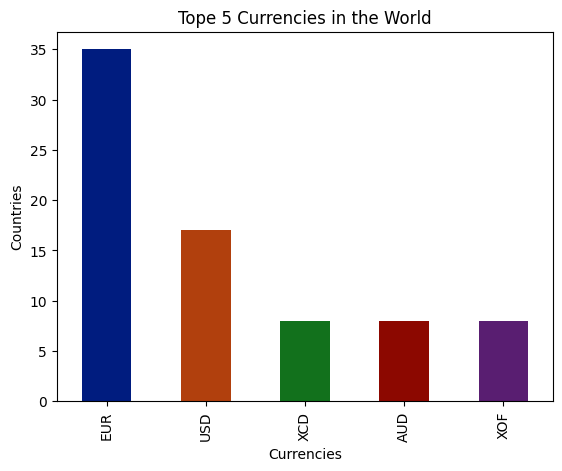

In [28]:
colors = sns.color_palette('dark', 5)
result_df['currency'].value_counts().nlargest(5).plot(kind='bar', color=colors) # count the number of countries using each currency from the dataframe and plots them
plt.xlabel('Currencies')
plt.ylabel('Countries')
plt.title('Tope 5 Currencies in the World')
plt.show()

As we can see, from the plot, Euro is the most commonly used currency in the world following by United States Dollar.

Find number of cities in each state in India

In [29]:
query = ''' Select * from city c where c.country_name = 'India' '''
result_df = get_result(query, cities)
In_states = result_df['state_name'].value_counts()
In_states = pd.DataFrame(In_states)
In_states.head()

,count
state_name,
Uttar Pradesh,621
Maharashtra,560
Tamil Nadu,350
Gujarat,308
Madhya Pradesh,273


As we can see, the state with the highest number of cities / towns in India is Uttar Pradesh.

Find the state with the highest number of cities in United States

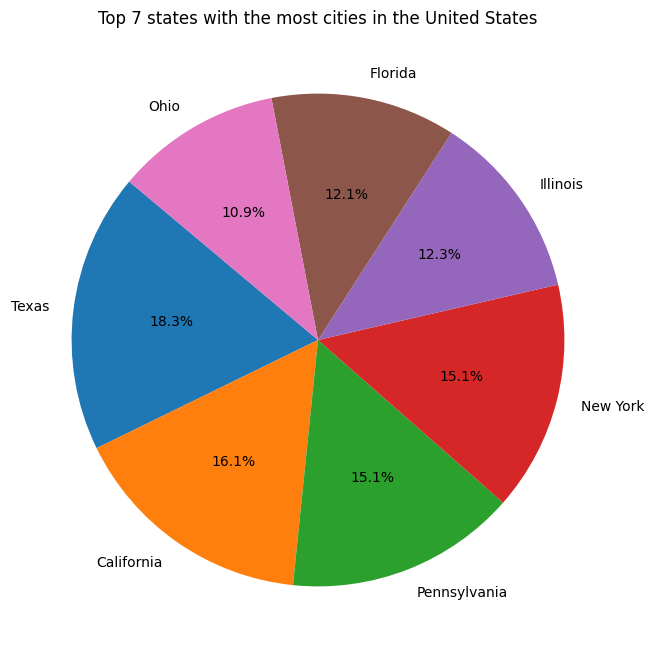

In [30]:
query = ''' Select * from city c where c.country_name = 'United States' '''
result_df = get_result(query, cities)
Us_states = result_df['state_name'].value_counts().nlargest(7)
plt.figure(figsize=(8, 8))  # Set the figure size
plt.pie(Us_states, labels=Us_states.index, autopct='%1.1f%%', startangle=140) # Plot the pie chart
plt.title('Top 7 states with the most cities in the United States')
plt.show()


As we can see, the state with the highest number of cities/towns in United States is Texas.

Find all countries that follow the GMT time zone

In [31]:
query = ''' select  c.name from countries c where c.timezones[0]['abbreviation'] = 'GMT' ''' # querying subelement of timezones
result_df = get_result(query, countries)
result_df

,name
0,Burkina Faso
1,Cote D'Ivoire (Ivory Coast)
2,Gambia The
3,Ghana
4,Greenland
5,Guernsey and Alderney
6,Guinea
7,Guinea-Bissau
8,Iceland
9,Ireland


As we can see, there are 20 countries that follow the GMT time zone.

***User-defined functions on Cosmos DB***

Calculate the distance between two countries or states or cities

In [32]:
def cal_distance(collection, place1, place2):
    ''' 
    Calculate the distance between two places in the collection

    parameters: 
        collection: Collection
        place1: string
        place2: string

    returns: 
        distance: float
    '''
    query01 = f"SELECT c.longitude, c.latitude FROM collection c WHERE c.name = '{place1}'"
    query02 = f"SELECT c.longitude, c.latitude FROM collection c WHERE c.name = '{place2}'"
    result01 = get_result(query01, collection)
    result02 = get_result(query02, collection)

    lo1 = float(result01['longitude'][0]) # get the longitude and latitude from the result as float
    la1 = float(result01['latitude'][0])
    lo2 = float(result02['longitude'][0])
    la2 = float(result02['latitude'][0])

    distance =round(math.sqrt(math.pow(69.1 * (la2 - la1), 2) + math.pow(69.1 * (lo1 - lo2) * math.cos(la1 / 57.3), 2)), 1) # math to calculate the distance in miles
    return print("The distance between {} and {} is {} miles".format(place1, place2, distance))

The distance shown here may vary from actual distance because they are calculated on the basis of latitude and longitude.

In [33]:
cal_distance(countries, 'United States', 'United Kingdom')

The distance between United States and United Kingdom is 5289.9 miles


In [34]:
cal_distance(states, 'California', 'Florida')

The distance between California and Florida is 2190.3 miles


In [35]:
cal_distance(cities, 'Chennai', 'Mumbai')

The distance between Chennai and Mumbai is 647.2 miles


In [36]:
# Close the client
client= None